In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!/home/dattalab/code/ArenaSDK_v0.1.68_Linux_x64/ArenaSDK_Linux_x64/Utilities/IpConfigUtility /list

In [3]:
from multicamera_acquisition.interfaces.arduino import (
    packIntAsLong,
    wait_for_serial_confirmation,
)
import struct
import time
import numpy as np


from multicamera_acquisition.paths import ensure_dir
from multicamera_acquisition.acquisition import acquire_video

/home/dattalab/code/multicamera_acquisition/multicamera_acquisition/interfaces/arduino.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
from  multicamera_acquisition.interfaces.camera_lucid import find_helios_devices

In [5]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [6]:
from multicamera_acquisition.usb_utils import reset_usb

In [7]:
import usb.core
l = list(usb.core.find(find_all=True))

In [8]:
reset_usb(products=[
    "a2A1920-160umBAS",
    "Azure Kinect 4K Camera", 
    "Azure Kinect Depth Camera", 
    "Azure Kinect Microphone Array"
], verbose=True)

resetting Azure Kinect Depth Camera (0x45e, 0x97c))
resetting Azure Kinect 4K Camera (0x45e, 0x97d))
Error retrieving product info
resetting Azure Kinect Microphone Array (0x45e, 0x97e))
Error retrieving product info
Error retrieving product info
Error retrieving product info


### Check lucid helios devices

In [9]:
from arena_api.system import system
# Destroy device. Optional, implied by closing of module
system.destroy_device()
print("Destroyed all created devices")

Destroyed all created devices


In [10]:
devices = find_helios_devices()
camera_serials = np.array([c.nodemap['DeviceSerialNumber'].value for c in devices])
print(f'Serial numbers: {camera_serials}')

Serial numbers: ['232701394']


### Check kinect devices
- If an "error" is observed, unplug and replug them, then reset the notebook

In [11]:
!k4arecorder --list

Index:0	Serial:000483621712	Color:1.6.110	Depth:1.6.80


## Set up the camera

In [12]:
recording_duration_s = 10  # seconds
framerate = 30
exposure_time= 950 # 1000s
save_location = f'/home/dattalab/Videos/'
ensure_dir(save_location)
quality = 15
gain = 30
display = False
camera_list = [
    # azure
    
#         { 'name': 'azuretop', 'serial': '000483621712', 'brand':'azure', 'gpu':0, "display":True, "quality": quality},
        {'name': 'lucidtop', 'serial': '232701394', 'brand':'lucid', 'gpu':0, "display":True, "quality": quality},
   ]

### Ensure azures are connected

In [13]:
if np.any([i["brand"] == 'azure' for i in camera_list]):
    from multicamera_acquisition.interfaces.camera_azure import get_camera_indexes
    camera_indices = get_camera_indexes({i['name']:i['serial'] for i in camera_list if i['brand'] == 'azure'})

    # add indices to camera list
    for name in camera_indices.keys():
        for i in range(len(camera_list)):
            if camera_list[i]['name'] == name:
                camera_list[i]['azure_index'] = camera_indices[name]
    print(camera_indices)

### Run recording

In [14]:
#output_location, camera_list = acquire_video(
output_location, camera_list = acquire_video(
    save_location,
    camera_list,
    frame_timeout = 1000, # how long to allow frames to attempt to grab bpcie lanesefore a timeout
    azure_recording=False,
    azure_framerate = 30,  # azure's frame rate in this case.
    framerate=framerate,
    display_framerate = 30,
    recording_duration_s = recording_duration_s,
    serial_timeout_duration_s=0.1,
    overwrite=True,
    append_datetime=True,
    dropped_frame_warnings=True,
    max_video_frames = framerate * 60,
    verbose=True
    
)

INFO:root:Checking cameras...
INFO:root:Initializing cameras...
INFO:root:Camera lucidtop...


Save location exists: True


DEBUG:root:running init for camera 232701394
DEBUG:root:almost done running init for camera 232701394
DEBUG:root:done running init for camera 232701394
INFO:root:Initialized lucidtop (232701394)
INFO:root:Initializing Arduino...
INFO:root:Waiting 2s to wait for arduino to connect...
INFO:root:Preparing acquisition loops
INFO:root:Telling arduino to start recording
DEBUG:root:Inverse framerate: 33333; num cycles: 300


(480, 640) <class 'numpy.ndarray'> <class 'numpy.float64'> 897.5
frame bounds 2379.5 -0.25 694.25


DEBUG:root:FRAME SHAPE (480, 640)
DEBUG:root:filename: ffmpeg -y -framerate 30 -f rawvideo -s 640x480 -pix_fmt gray16 -i - -an -vcodec ffv1 /home/dattalab/Videos/23-11-20-10-41-13-126514/lucidtop.232701394.avi


ffmpeg -y -framerate 30 -f rawvideo -s 640x480 -pix_fmt gray16 -i - -an -vcodec ffv1 /home/dattalab/Videos/23-11-20-10-41-13-126514/lucidtop.232701394.avi


/home/dattalab/code/multicamera_acquisition/multicamera_acquisition/interfaces/arduino.py:32: UserWarning: PySerial: "Start" confirmation expected, got "S"". Trying again.
  warnings.warn(
DEBUG:root:stopping acquisition loop (lucidtop)
DEBUG:root:joining acquisition loop (lucidtop)


In [ ]:
logger.setLevel(logging.WARNING)

### Count frames

In [15]:
import imageio
from pathlib import Path

In [16]:
# count each frame
for camera_dict in camera_list:
    name = camera_dict["name"]
    serial_number = camera_dict["serial"]
    try:
        video_file = Path(output_location) / f"{name}.{serial_number}.avi"
        vid = imageio.get_reader(video_file.as_posix(),  'ffmpeg')
    except:
        video_file = Path(output_location) / f"{name}.{serial_number}.mp4"
        vid = imageio.get_reader(video_file.as_posix(),  'ffmpeg')
    num_frames=vid.count_frames()
    print(f"Frames ({name}):", num_frames)

Frames (lucidtop): 285


### Plot frames

In [17]:
from pathlib2 import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.set_loglevel(level = 'error')

DEBUG:matplotlib:matplotlib data path: /home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:CONFIGDIR=/home/dattalab/.config/matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:CACHEDIR=/home/dattalab/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/dattalab/.cache/matplotlib/fontlist-v330.json
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [18]:
video_out = output_location

In [19]:
name = camera_list[0]['name']
df = pd.read_csv(list(video_out.glob(f'{name}*.csv'))[0])

In [20]:
df

,frame_id,frame_timestamp,frame_image_uid,queue_size
0,0,380409925552,1.700495e+09,0
1,1,380443258032,1.700495e+09,0
2,2,380476590512,1.700495e+09,0
3,3,380509922992,1.700495e+09,0
4,4,380543255472,1.700495e+09,0
...,...,...,...,...
280,280,389743142672,1.700495e+09,0
281,281,389776475152,1.700495e+09,0
282,282,389809807792,1.700495e+09,0
283,283,389843140272,1.700495e+09,0


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', si

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-p

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', name='Liberation Sans Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstNaskh.ttf', name='KacstNaskh', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:fi

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-BoldOblique.ttf', name='Garuda', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-BoldItalic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypo.ttf', name='Tlwg Typo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Oblique.ttf', name='Tlwg Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Meera-Regular.ttf', name='Meera', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst-one/Kac

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree-Bold.ttf', name='Waree', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='condensed', size='scalable')) = 1.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Bold.ttf', name='Norasi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-BoldItalic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Regular.ttf', name='Rasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak-fonts/Samyak-Tamil.ttf', name='Samyak Tamil', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-Oblique.ttf', name='Tlwg Typist', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Regular.ttf', name='Yrsa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/s

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-telugu/Lohit-Telugu.ttf', name='Lohit Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Chilanka-Regular.otf', name='Chilanka', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-BdIta.otf', name='C059', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/sh

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-pack

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/dattalab/anaconda3/envs/multicam/lib/python3.10/site-pac

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Nakula/nakula.ttf', name='Nakula', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-BoldItalic.ttf', name='Kinnari', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-BoldItalic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/aakar-medium.ttf', name='aakar', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Oblique.ttf', name='Purisa', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-guru-extra/Saab.ttf', name='Saab', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/Meera-Regular.ttf', name='Meera', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst-one/KacstOne-Bold.ttf', name='KacstOne', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/URWBookman-Light.otf', name='URW Bookman', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/mry_KacstQurn.ttf', name='mry_KacstQurn', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-Regular.ttf', name='Rasa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 0.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst-one/KacstOne.ttf', name='KacstOne', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee.ttf', name='Sawasdee', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeS

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-Regular.ttf', name='Yrsa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono-Oblique.ttf', name='Tlwg Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Italic.ttf', name='Norasi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree-Oblique.ttf', name='Waree', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/RaghuMalay

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fnam

lucidtop


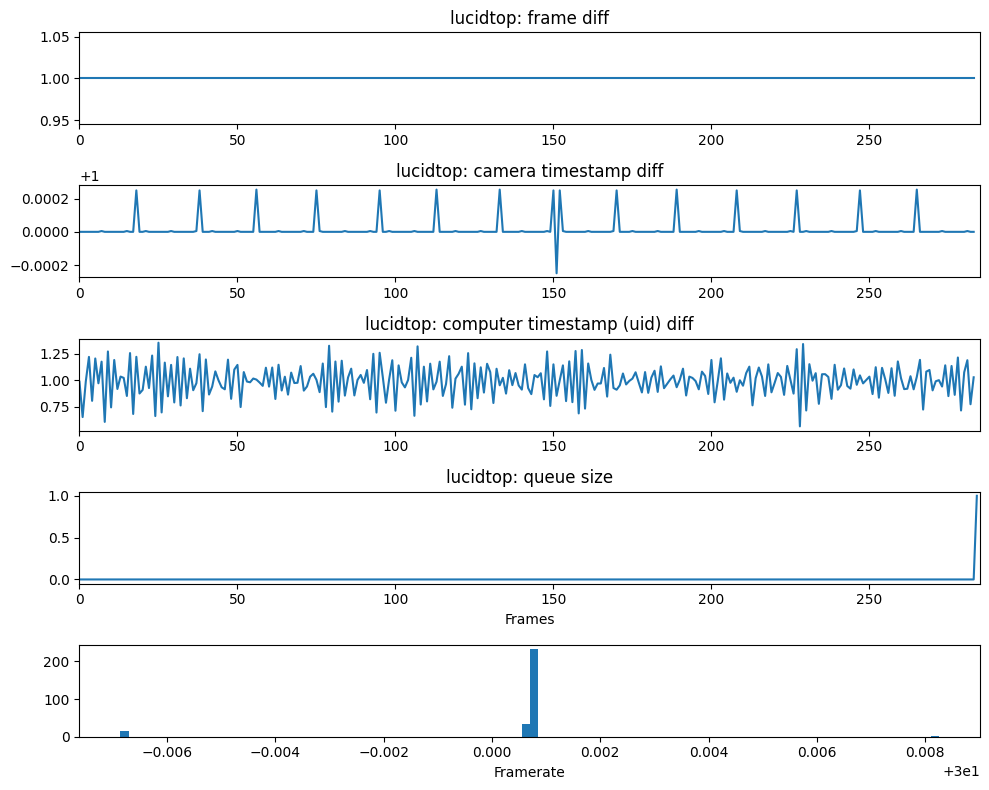

9.4665472
30.00037859632707


In [21]:
for cam in camera_list:
    name = cam['name']
    print(name)
    df = pd.read_csv(list(video_out.glob(f'{name}*.csv'))[0])
    fig, axs = plt.subplots(ncols = 1, nrows = 5, gridspec_kw= {'height_ratios':[1,1,1,1,1]}, figsize=(10,8))
    nrows = len(df)
    axs[0].set_title(f"{name}: frame diff")
    axs[0].plot(np.diff(df.frame_id.values))
    axs[0].set_xlim([0, len(df)])
    axs[1].set_title(f"{name}: camera timestamp diff")
    axs[1].plot(np.diff(df.frame_timestamp.values) / np.median(np.diff(df.frame_timestamp.values)))
    #axs[1].plot(np.diff(df.frame_timestamp.values))
    axs[1].set_xlim([0, len(df)])
    axs[2].set_title(f"{name}: computer timestamp (uid) diff")
    axs[2].plot(np.diff(df.frame_image_uid.values) / np.median(np.diff(df.frame_image_uid.values)))
    axs[2].set_xlim([0, len(df)])
    axs[3].set_title(f"{name}: queue size")
    axs[3].plot(df.queue_size.values)
    axs[3].set_xlim([0, len(df)])
    axs[3].set_xlabel('Frames')
    axs[4].hist(1/(np.diff(df.frame_timestamp.values)* 1e-9), bins=100);
    axs[4].set_xlabel('Framerate')
    plt.tight_layout()
    plt.show()
    
    time_elapsed = (df.frame_timestamp.values[-1] - df.frame_timestamp.values[0]) * 1e-9
    avg_framerate = np.mean(np.diff(df.frame_timestamp.values))
    print(time_elapsed)
    print(1 / (avg_framerate* 1e-9))

### Plot image

In [22]:
filename = Path(output_location) / f"{name}.{serial_number}.avi"

In [23]:
filename

PosixPath('/home/dattalab/Videos/23-11-20-10-36-08-366698/lucidtop.232701394.avi')

In [24]:
from multicamera_acquisition.video_io_ffmpeg import read_frames

(array([63835., 28928., 95205., 43537., 16517., 13960., 35516., 21528.,
        24381., 25233.]),
 array([   0. ,  237.8,  475.6,  713.4,  951.2, 1189. , 1426.8, 1664.6,
        1902.4, 2140.2, 2378. ]),
 <BarContainer object of 10 artists>)

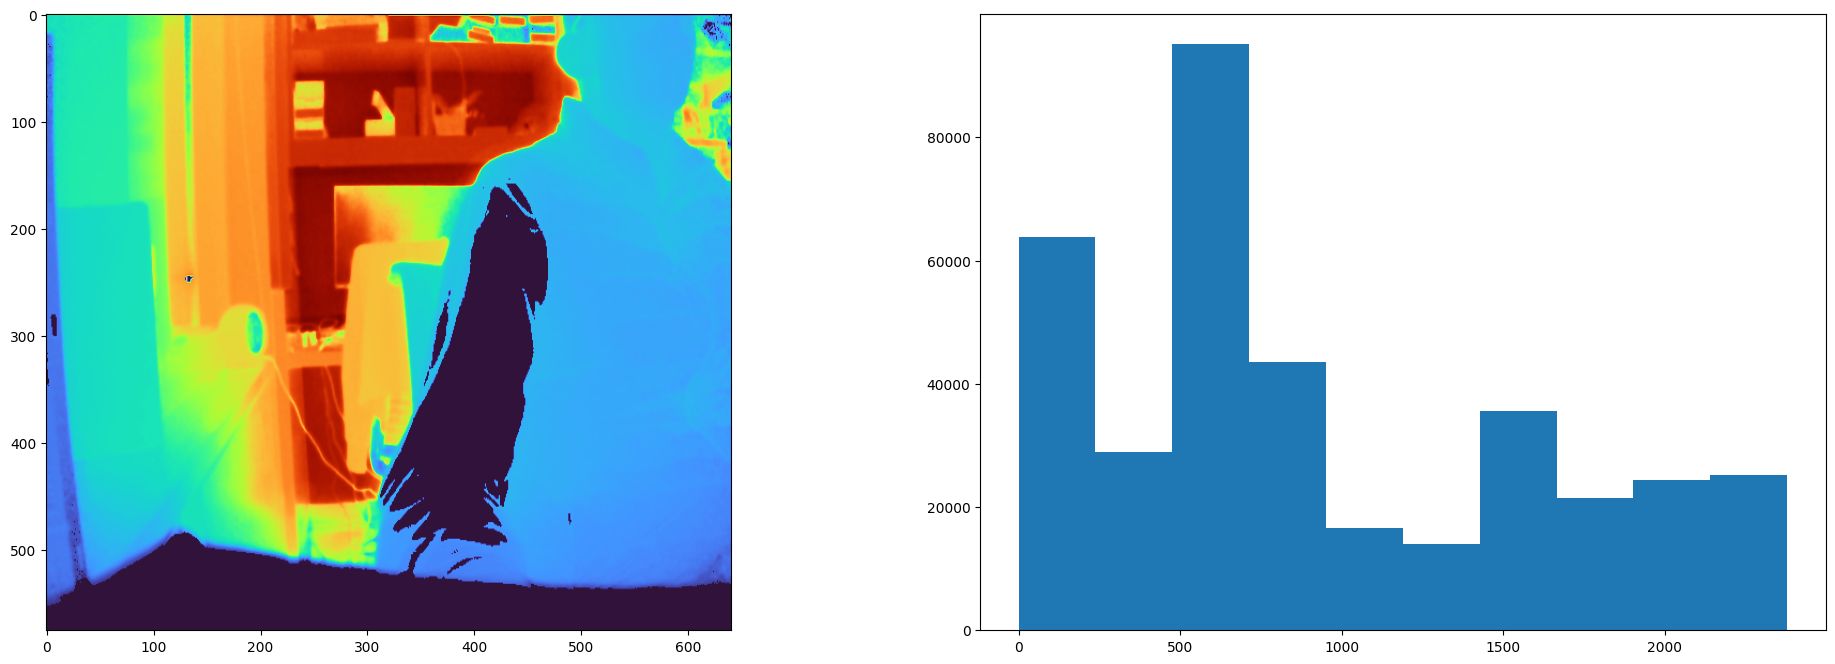

In [25]:
frames = read_frames(
    filename, 
    pixel_format = "gray16",
    frames = list(range(10))
)
fig, axs = plt.subplots(figsize=(24, 8), ncols =2)
axs[0].imshow(frames[1], cmap = 'turbo')
axs[1].hist(frames[1].flatten())

In [ ]:
filename

In [ ]:
frames.shape

libusb: error [udev_hotplug_event] ignoring udev action bind
